# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-209B Advanced Data Science
## Advanced Section 8: Generative Adversarial Networks

**Harvard University**<br>
**Spring 2019**<br>
**Section instructor:** Vincent Casser<br>
**Instructors:** Pavlos Protopapas and Mark Glickman<br>
**Authors:** Vincent Casser, Pavlos Protopapas

We describe a minimalistic implementation of Generative Adversarial Networks (GANs) in Keras. We train a simple GAN for the task of face synthesis on the CelebA dataset. The goal of this is to enhance understanding of the concepts, and to give an easy to understand hands-on example.

To increase the visual quality of samples, you are encouraged to try out some tricks you learned in class, such as switching to Wasserstein GANs (WGANs), applying label smoothing, expanding and regularizing the architecture or trying pretraining.

## Imports.

In [12]:
import keras
from keras.layers import *
from keras.datasets import cifar10
import glob, cv2, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

## Global Parameters.

In [25]:
SPATIAL_DIM = 64 # Spatial dimensions of the images.
LATENT_DIM = 100 # Dimensionality of the noise vector.
BATCH_SIZE = 32 # Batchsize to use for training.
DISC_UPDATES = 1  # Number of discriminator updates per training iteration.
GEN_UPDATES = 1 # Nmber of generator updates per training iteration.

FILTER_SIZE = 5 # Filter size to be applied throughout all convolutional layers.
NUM_LOAD = 10000 # Number of images to load from CelebA. Fit also according to the available memory on your machine.
NET_CAPACITY = 16 # General factor to globally change the number of convolutional filters.

PROGRESS_INTERVAL = 80 # Number of iterations after which current samples will be plotted.
ROOT_DIR = 'visualization' # Directory where generated samples should be saved to.

if not os.path.isdir(ROOT_DIR):
    os.mkdir(ROOT_DIR)

## Prepare Data.

We use the CelebA face dataset.

In [14]:
def plot_image(x):
    plt.imshow(x * 0.5 + 0.5)

((10000, 64, 64, 3), -1.0, 1.0)

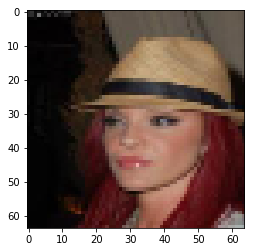

In [15]:
X = []
# Reference to CelebA dataset here.
faces = glob.glob('../Harvard/ComputeFest 2019/celeba/img_align_celeba/*.jpg')

for i, f in enumerate(faces):
    img = cv2.imread(f)
    img = cv2.resize(img, (SPATIAL_DIM, SPATIAL_DIM))
    img = np.flip(img, axis=2)
    img = img.astype(np.float32) / 127.5 - 1.0
    X.append(img)
    if i >= NUM_LOAD - 1:
        break
X = np.array(X)
plot_image(X[4])
X.shape, X.min(), X.max()

## Define Architectures.

In [16]:
def add_encoder_block(x, filters, filter_size):
    x = Conv2D(filters, filter_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, filter_size, padding='same', strides=2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.3)(x)
    return x

In [17]:
def build_discriminator(start_filters, spatial_dim, filter_size):
    inp = Input(shape=(spatial_dim, spatial_dim, 3))
    
    # Encoding blocks downsample the image.
    x = add_encoder_block(inp, start_filters, filter_size)
    x = add_encoder_block(x, start_filters * 2, filter_size)
    x = add_encoder_block(x, start_filters * 4, filter_size)
    x = add_encoder_block(x, start_filters * 8, filter_size)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs=inp, outputs=x)

In [18]:
def add_decoder_block(x, filters, filter_size):
    x = Deconvolution2D(filters, filter_size, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.3)(x)
    return x

In [19]:
def build_generator(start_filters, filter_size, latent_dim):
    inp = Input(shape=(latent_dim,))
    
    # Projection.
    x = Dense(4 * 4 * (start_filters * 8), input_dim=latent_dim)(inp)
    x = BatchNormalization()(x)
    x = Reshape(target_shape=(4, 4, start_filters * 8))(x)
    
    # Decoding blocks upsample the image.
    x = add_decoder_block(x, start_filters * 4, filter_size)
    x = add_decoder_block(x, start_filters * 2, filter_size)
    x = add_decoder_block(x, start_filters, filter_size)
    x = add_decoder_block(x, start_filters, filter_size)    
    
    x = Conv2D(3, kernel_size=5, padding='same', activation='tanh')(x)
    return keras.Model(inputs=inp, outputs=x)

## Training.

First, we construct all models.

In [20]:
def construct_models(verbose=False):
    # 1. Build discriminator.
    discriminator = build_discriminator(NET_CAPACITY, SPATIAL_DIM, FILTER_SIZE)
    discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002), metrics=['mae'])

    # 2. Build generator.
    generator = build_generator(NET_CAPACITY, FILTER_SIZE, LATENT_DIM)

    # 3. Build full GAN setup by stacking generator and discriminator.
    gan = keras.Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False # Fix the discriminator part in the full setup.
    gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002), metrics=['mae'])

    if verbose: # Print model summaries for debugging purposes.
        generator.summary()
        discriminator.summary()
        gan.summary()
    return generator, discriminator, gan

The code below executes the main training loop.

In [22]:
def run_training(start_it=0, num_epochs=1000):
    config_name = 'gan_cap' + str(NET_CAPACITY) + '_batch' + str(BATCH_SIZE) + '_filt' + str(FILTER_SIZE) + '_disc' + str(DISC_UPDATES) + '_gen' + str(GEN_UPDATES)
    folder = os.path.join(ROOT_DIR, config_name)

    if not os.path.isdir(folder):
        os.mkdir(folder)
    avg_loss_discriminator = []
    avg_loss_generator = []
    total_it = start_it

    for epoch in range(num_epochs):
        loss_discriminator = []
        loss_generator = []
        for it in range(200): 

            # Update discriminator.
            for i in range(DISC_UPDATES): 
                # Fetch real examples (you could sample unique entries, too).
                imgs_real = X[np.random.randint(0, X.shape[0], size=BATCH_SIZE)]

                # Generate fake examples.
                noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
                imgs_fake = generator.predict(noise)

                d_loss_real = discriminator.train_on_batch(imgs_real, np.ones([BATCH_SIZE]))[1]
                d_loss_fake = discriminator.train_on_batch(imgs_fake, np.zeros([BATCH_SIZE]))[1]
            
            # Progress visualizations.
            if total_it % PROGRESS_INTERVAL == 0:
                plt.figure(figsize=(5,2))
                # We sample separate images.
                num_vis = min(BATCH_SIZE, 8)
                imgs_real = X[np.random.randint(0, X.shape[0], size=num_vis)]
                noise = np.random.randn(num_vis, LATENT_DIM)
                imgs_fake = generator.predict(noise)
                for obj_plot in [imgs_fake, imgs_real]:
                    plt.figure(figsize=(num_vis * 3, 3))
                    for b in range(num_vis):
                        disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])
                        plt.subplot(1, num_vis, b + 1)
                        plt.title(str(round(disc_score, 3)))
                        plot_image(obj_plot[b]) 
                    if obj_plot is imgs_fake:
                        plt.savefig(os.path.join(folder, str(total_it).zfill(10) + '.jpg'), format='jpg', bbox_inches='tight')
                    plt.show()  

            # Update generator.
            loss = 0
            y = np.ones([BATCH_SIZE, 1]) 
            for j in range(GEN_UPDATES):
                noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
                loss += gan.train_on_batch(noise, y)[1]

            loss_discriminator.append((d_loss_real + d_loss_fake) / 2.)        
            loss_generator.append(loss / GEN_UPDATES)
            total_it += 1

        # Progress visualization.
        clear_output(True)
        print('Epoch', epoch)
        avg_loss_discriminator.append(np.mean(loss_discriminator))
        avg_loss_generator.append(np.mean(loss_generator))
        plt.plot(range(len(avg_loss_discriminator)), avg_loss_discriminator)
        plt.plot(range(len(avg_loss_generator)), avg_loss_generator)
        plt.legend(['discriminator loss', 'generator loss'])
        plt.show()

In [ ]:
generator, discriminator, gan = construct_models(verbose=True)

In [ ]:
run_training()

# Sample from Trained GAN.

For this GAN, we can see instances of mode collapse below.

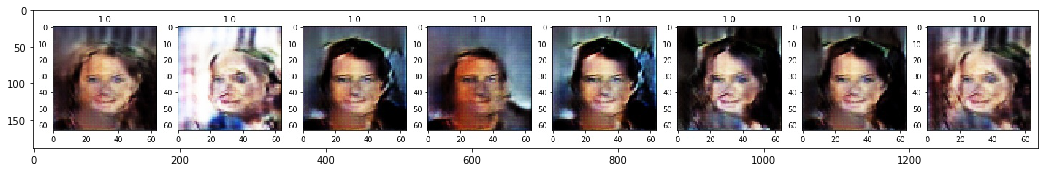

In [10]:
NUM_SAMPLES = 7
plt.figure(figsize=(NUM_SAMPLES * 3, 3))

for i in range(NUM_SAMPLES):
    noise = np.random.randn(1, LATENT_DIM) 
    pred_raw = generator.predict(noise)[0]
    pred = pred_raw * 0.5 + 0.5
    plt.subplot(1, NUM_SAMPLES, i + 1)
    plt.imshow(pred)
plt.show()